## Conversational Analysis: Data Import, Exploration, and Cleaning

In this notebook, we'll work through the process of importing the [Santa Barbara Corpus of Spoken American English](http://www.linguistics.ucsb.edu/research/santa-barbara-corpus) into Python and perform some preliminary data cleaning.

Before running this notebook, make sure that the downloaded corpus file is unzipped and that the `SBCSAE` folder is located in the same directory as this notebook. For more information, see the `README.md` file on GitHub (or, optionally, in this directory if you're running the notebook locally).

### Initial Library/Package Imports

In [1]:
import pandas as pd
import numpy as np
import math
import pylangacq as pla
import os
import re
import matplotlib.pyplot as plt

### Importing/Reading the Corpus

In [2]:
sbc = pla.read_chat('SBCSAE/*.cha')

In [3]:
print(sbc.number_of_files())

60


By default, the .filenames() method will return the filenames in `set` format, so we'll convert it to an unordered list, which we'll sort as well.

In [4]:
filenames = list(sbc.filenames())
filenames.sort()
print(filenames[0]) # let's take a look at the filename format - it should be absolute

/Users/jeremy/ds/metis/coursework/conversation_analysis/SBCSAE/SBC001.cha


Organize words in order of files and view them to get a sense of the data (words/conversations).

In [5]:
words_by_files = sbc.words(by_files=True) # dict(filename: word list for that file)
print(words_by_files[filenames[0]][:25]) # view first 50 words of first file in filenames list

['So', 'you', "don't", 'need', 'to', 'go', 'borrow', 'equipment', 'from', 'anybody', 'to', '/.', 'to', 'do', 'the', 'feet', '?', '⌈', 'Do', 'the', 'hooves', '⌉', '?', '⌊', '⌋']


Notice that there are some symbols in the corpus that are considered as "words" - we'll need to clean this up. The `PyLangAcq` package actually preserves the linguistic encodings of conversation participants' utterances from the `.cha` files, which is a wonderful feature, though we'll just stay concerned with the words themselves for the sake of this project. This means we'll need to remove these linguistic symbols from our corpus in order to perform topic modeling properly.

### Exploring the Data

How many words are in each file/conversation? Let's find out:

In [6]:
conv_word_totals = []
for filename in sorted(filenames):
    conv_word_totals.append((len(words_by_files[filename]), os.path.basename(filename)))
word_totals = list((x for (x, y) in sorted(conv_word_totals)))
conv_filenames = list((y for (x, y) in sorted(conv_word_totals)))

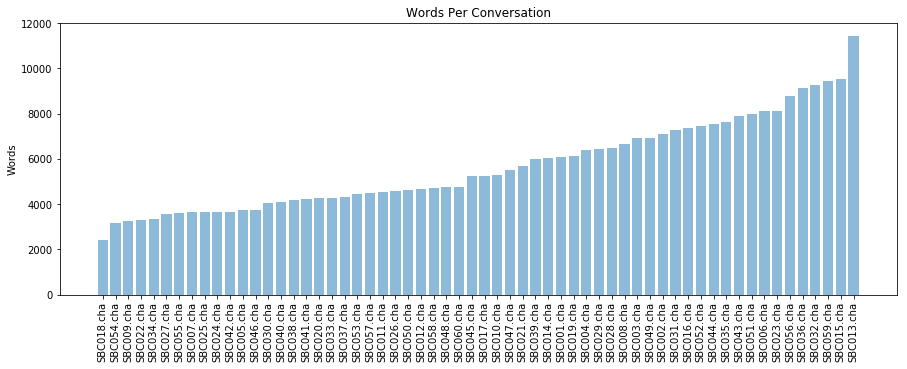

In [7]:
y_pos = np.arange(len(conv_filenames))

plt.figure(figsize = (15, 5))

plt.bar(y_pos, word_totals, align = 'center', alpha = 0.5)
plt.xticks(y_pos, conv_filenames, rotation = 90)
plt.ylabel('Words')
plt.title('Words Per Conversation')

plt.show()

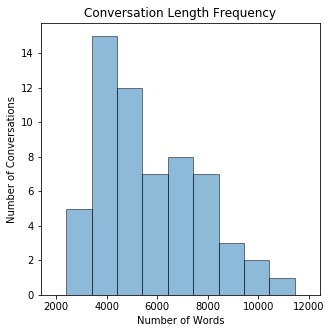

In [8]:
# add histogram of ranges of word frequency
bins = np.linspace(math.ceil(min(word_totals)), 
                   math.floor(max(word_totals)),
                   10)

plt.figure(figsize = (5, 5))
plt.xlim([min(word_totals)-1000, max(word_totals)+1000])
plt.hist(word_totals, bins=bins, alpha=0.5, edgecolor="k")
plt.title('Conversation Length Frequency')
plt.xlabel('Number of Words')
plt.ylabel('Number of Conversations')

plt.show()

*Note: need to expand EDA.*

*To-do: Measures of central tendency, spread, histograms, and correlations between:*

- *Number of words per conversation*
- *Number of words per speaker (across all conversations)*
- *Number of words per speaker (between conversations - can see whether there's a tendency for one speaker to dominate a conversation)*
- *Number of words per utterance (across all conversations)*
- *Number of words per utterance (between conversations)*
- *Number of words per utterance, per speaker*

Can we find out the age of each speaker? Unfortunately, no.

In [9]:
print(sbc.age().values())
# Prints None because none of the participants' ages were recorded
# Would have been cool to see if/how speakers of different ages use dialogue acts

dict_values([None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None])


Let's explore the structure of the data by going through a single conversation. To begin, let's put a single file into a reader so we can work with it programatically.

In [10]:
sbc_1 = pla.read_chat(filenames[0])

Use the `.sents()` method to explore just the sentences of a given conversation:

In [11]:
all_sents = sbc_1.sents()
print(all_sents[:2])

[['So', 'you', "don't", 'need', 'to', 'go', 'borrow', 'equipment', 'from', 'anybody', 'to', '/.'], ['to', 'do', 'the', 'feet', '?']]


Use the `.participant_codes()` method to view a conversation's participant codes, usually an all-caps abbreviation of a participant's name. (Notice that the `'ENV'` code represents sound from the surrounding environment in a given conversation, as this corpus consists of recordings "in the wild," not in a lab or other controlled environment.)

In [12]:
participants = list(sbc_1.participant_codes())
print(participants)

['DORI', 'LYNN', 'LENO', 'ENV']


In [13]:
# To get sentences by speaker alone. Not necessary at this step

# p_sents = []
# for p in participants:
#     p_sents.append([p, sbc_1.sents(participant=p)])
# p_sents[2][1][0]

### Data Cleaning

Let's examine one conversation/utterance and test the built-in `clean_utterance()` function:

In [14]:
print(sbc_1.utterances()[7][1])
print(pla.util.clean_utterance(sbc_1.utterances()[7][1]))

⌊&=in We're not⌋ gonna do the feet today I'm gonna wait till like early in the morning: to do those cause y- +/.
⌊&=in We're not⌋ gonna do the feet today I'm gonna wait till like early in the morning: to do those cause y- +/.


I can't see any difference between the vanilla utterance and "cleaned" utterance, but let's check this programmatically to make certain that the `pla.util.clean_utterance()` function isn't altering the string (though we'd think that it would):

In [15]:
is_not_cleaned = (sbc_1.utterances()[7][1] == pla.util.clean_utterance(sbc_1.utterances()[7][1]))
print(is_not_cleaned)

True


Okay, it's the same, in this case - we'll still use the function later down the line in case it picks up on anything else. Here's [the documentation for `pla.util.clean_utterance()`](http://pylangacq.org/_modules/pylangacq/util.html#clean_utterance).

Let's explore the data types before putting the utterances into a DataFrame:

In [16]:
conv1 = sbc_1.utterances()

In [17]:
print(type(conv1))

<class 'list'>


In [18]:
print(type(conv1[1]))

<class 'tuple'>


In [19]:
df = pd.DataFrame(conv1, columns = ['P_Code', 'Utterance'])

In [20]:
print(len(df))

667


In [21]:
print(df['Utterance'][3])

⌊ ⌋ ΫWell we're gonna have to find somewhere to get somethingΫ .


The following function will clean the text of an utterance (string) of any extraneous linguistic coding. Many of the below symbols taken from ~~here: https://talkbank.org/CABank/codes.html~~

... here: https://talkbank.org/manuals/CHAT.pdf#page=87 - the above link seems to be dead.

In [22]:
def clean_text(utterance):
    """ Takes a string and returns a cleaned version of the same string without linguistic symbols.
    """
    # Do this first: remove symbols, numbers, and consecutive 'x's
    cleaned_string = re.sub(r'[⌊⌋+/&=Ϋ:⌈⌉↑↓⇗↗→↘⇘∞≈≋≡∙∆∇⁎⁇°◉▁▔☺♋∬∲§∾↻Ἡ„‡ạʰāʔʕšˈˌ‹›〔〕“”]|\d|xx|XX', '', utterance)
    
    # now try the built-in text cleaning function
    cleaned_string = pla.util.clean_utterance(cleaned_string)
    
    # Repeat the removal of consecutive 'x's
    cleaned_string = re.sub(r'xx|XX', '', cleaned_string)
    
    return(cleaned_string)

In [23]:
df['Utterance'] = df['Utterance'].apply(clean_text)

Let's peak at our sample conversation DataFrame:

In [24]:
df.head(25)

,P_Code,Utterance
0,LENO,So you don't need to go borrow equipment from ...
1,LENO,to do the feet ?
2,LENO,Do the hooves ?
3,LYNN,Well we're gonna have to find somewhere to get...
4,DORI,So Mae- ...
5,LYNN,I'm gonna ...
6,DORI,Mae Lynne .
7,LYNN,in We're not gonna do the feet today I'm gonna...
8,LYNN,I mean you get so tired .
9,LYNN,n- you just it takes uh .


In [25]:
df.tail(25)

,P_Code,Utterance
642,LYNN,This is the type of person that is like a herm...
643,LYNN,I don't know what you'd call him .
644,LYNN,.
645,DORI,Well they were rai- raised backward .
646,LYNN,He's like ...
647,DORI,Uh back woods .
648,LYNN,Back woodsy .
649,DORI,raised in the mountains .
650,DORI,didn't d- ...
651,LYNN,Never came down out of the mountains .


We need a way to get rid of empty utterances. We'll deal with this in the next notebook.

### Creating new DataFrames for all conversations

The following function will convert a conversation to a DataFrame, taking a filename and returning a DataFrame of the respective conversation's utterances as rows.

In [26]:
def conv_to_df(filepath):
    
    # import from specific file
    reader = pla.read_chat(filepath)
    
    # get the utterances as a list of tuples
    conv = reader.utterances()
    
    # put this list of tuples into a DataFrame
    df = pd.DataFrame(conv, columns = ['P_Code', 'Utterance'])
    
    # clean utterances of linguistic coding
    df['Utterance'] = df['Utterance'].apply(clean_text)
    
    return df

Let's make a list containing the DataFrames of each conversation:

In [27]:
corpus_dfs = []
for f in range(len(filenames)):
    corpus_dfs.append(conv_to_df(sorted(filenames)[f]))

Another peak at what a DataFrame of utterances looks like:

In [28]:
corpus_dfs[59][:5]

,P_Code,Utterance
0,ALAN,I got a story to tell you it's a shaggy dog st...
1,JON,.
2,ALAN,It must've been four to six months after my da...
3,ALAN,That's how I remember it he died in sixty-s- ...
4,JON,Oh God .


Now we have all our conversations in DataFrames, with each row as an utterance. Each conversation DataFrame is stored in a single list object for simplicity.

*(Ideally we'd store this in a single DataFrame and save it as a `.csv` file - something I need to refactor and make associated changes in the next notebook.)*

We can save this file and work with it in a new notebook, in which we'll get to the nitty-gritty of the NLP details and  to do more NLP and make some models!

In [29]:
# import pickle here to easily save the list object and work with it in a new notebook
# NOTE: best to refactor the code and simply save one DataFrame as a .csv file - on to-do
# ... with a new column for "Conversation ID"
import pickle

In [30]:
with open('corpus_dataframes.p', 'wb') as f:
    pickle.dump(corpus_dfs, f)

See the next notebook, `NLP_&_Modeling.ipynb`, for, well, NLP & modeling!